In [156]:
# Imports für den Algorithmus
import pandas as pd
import numpy as np
from ast import literal_eval
from rake_nltk import Rake
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import itertools
from IPython.display import display

# Imports für die Evaluation
import matplotlib.pyplot as plt
import recmetrics

In [152]:
# Der Algorithmus mit Listenbereinigung

# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

df1 = pd.read_csv("tmdb_5000_movies.csv")
df2 = pd.read_csv("tmdb_5000_credits.csv")
data = pd.merge(df1, df2)
data.drop(['budget', 'homepage', 'original_language', 'id', 'release_date', 'popularity', 'tagline',
           'production_countries', 'production_companies', 'runtime', 'original_title', 'status', 
           'revenue', 'spoken_languages'], axis=1, inplace=True)
data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
data.drop(data[data.keywords == '[]'].index, inplace=True)
data.drop(data[data.genres == '[]'].index, inplace=True)
data.reset_index(inplace=True)

features = ['cast', 'keywords', 'genres', 'crew']
for feature in features:
    data[feature] = data[feature].apply(literal_eval)


def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan


def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        if len(names) > 7:
            names = names[:7]
        return names
    return []


data['director'] = data['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    data[feature] = data[feature].apply(get_list)

data.drop('crew', axis=1, inplace=True)

data['Key_words'] = ""
data['overview'] = data['overview'].apply(str)

for index, row in data.iterrows():
    plot = row['overview']
    r = Rake()
    r.extract_keywords_from_text(plot)
    key_words_dict_scores = r.get_word_degrees()
    row['Key_words'] = list(key_words_dict_scores.keys())


def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''


features = ['cast', 'keywords', 'director', 'genres', 'Key_words']

for feature in features:
    data[feature] = data[feature].apply(clean_data)


def create_soup(x):
    return ' '.join(x['Key_words']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(
        x['genres']) + ' ' + ' '.join(x['keywords'])


data['soup'] = data.apply(create_soup, axis=1)
data['index'] = data.index


display(data)

cv = CountVectorizer()
count_matrix = cv.fit_transform(data['soup'])
cosine_sim = cosine_similarity(count_matrix)

sim_scores = list(enumerate(cosine_sim[-1, :]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

def get_title_from_index(index):
    return data[data.index == index]['title'].values[0]


def get_index_from_title(title):
    index_list = []
    for i in range(len(title)):
        index_list.append(data[data.title == title[i]]['index'].values[0])
    return index_list

sorted_similar_movies = []

list_cos_sim = []

mae_list = []
rmse_list = []
list_index = set()

def make_recommendation(movie):
    global sorted_similar_movies
    counter = 0
                     
    movie_index = get_index_from_title(movie)

    length_list = len(movie)
    similar_movies_user_likes_list = []

    for i in range(length_list):
        similar_movies_user_likes_list.append(list(enumerate(cosine_sim[movie_index[i]])))

    list_of_similar_movies_user_likes = list(itertools.chain.from_iterable(similar_movies_user_likes_list))
    sorted_similar_movies_user_likes = sorted(list_of_similar_movies_user_likes, key=lambda x: x[1], reverse=True)[1:]

    for i in range(length_list):
        sorted_similar_movies_user_likes.pop(0)
    
    ##### Für jeden vorgeschlagenen Film werden die folgenden Operationen durchgeführt: #####
    for element in sorted_similar_movies_user_likes:
        
        ### Durchschnittswert Kosinus-Ähnlichkeit
        cos_sim = sorted_similar_movies_user_likes[counter][1]
        list_cos_sim.append(cos_sim)
        
        ### MAE und RMSE ###
        # actual - die reale Bewertung des Filmes wird abgegriffen
        actual = data["vote_average"][element[0]]
        # predicted - der Wert der Kosinus-Ähnlichkeit des Filmes 
        predicted = sorted_similar_movies_user_likes[counter][1]
        
        # Erster Teil der MAE: |Vorhersage - reale Bewertung|
        # Erster Teil der RMSE: |Vorhersage - reale Bewertung|**2
        # Reale Bewertung durch 10 geteilt, damit der Wert auf die gleiche Nachkommastelle wie die Vorhersage gebracht wird
        mae = abs(predicted - actual/10) 
        rmse = abs(predicted - actual/10)**2
        # Anschließend in eine Liste gepackt
        mae_list.append(mae)
        rmse_list.append(rmse)
        
        
        ### Coverage ###
        list_index.add(element[0])
        
        counter = counter + 1
        if counter >= 6:
            break

,index,genres,keywords,overview,title,vote_average,vote_count,movie_id,cast,director,Key_words,soup
0,0,"[action, adventure, fantasy, sciencefiction]","[cultureclash, future, spacewar, spacecolony, ...","In the 22nd century, a paraplegic Marine is di...",Avatar,7.2,11800,19995,"[samworthington, zoesaldana, sigourneyweaver, ...",jamescameron,,samworthington zoesaldana sigourneyweaver ste...
1,1,"[adventure, fantasy, action]","[ocean, drugabuse, exoticisland, eastindiatrad...","Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End,6.9,4500,285,"[johnnydepp, orlandobloom, keiraknightley, ste...",goreverbinski,,johnnydepp orlandobloom keiraknightley stella...
2,2,"[action, adventure, crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...",A cryptic message from Bond’s past sends him o...,Spectre,6.3,4466,206647,"[danielcraig, christophwaltz, léaseydoux, ralp...",sammendes,,danielcraig christophwaltz léaseydoux ralphfi...
3,3,"[action, crime, drama, thriller]","[dccomics, crimefighter, terrorist, secretiden...",Following the death of District Attorney Harve...,The Dark Knight Rises,7.6,9106,49026,"[christianbale, michaelcaine, garyoldman, anne...",christophernolan,,christianbale michaelcaine garyoldman annehat...
4,4,"[action, adventure, sciencefiction]","[basedonnovel, mars, medallion, spacetravel, p...","John Carter is a war-weary, former military ca...",John Carter,6.1,2124,49529,"[taylorkitsch, lynncollins, samanthamorton, wi...",andrewstanton,,taylorkitsch lynncollins samanthamorton wille...
...,...,...,...,...,...,...,...,...,...,...,...,...
4390,4390,[drama],"[gang, audition, policefake, homeless, actress]",A young woman in L.A. is having a bad day: she...,Bang,6.0,1,124606,"[darlingnarita, petergreene, michaelnewland, e...",ashbaron-cohen,,darlingnarita petergreene michaelnewland erik...
4391,4391,"[sciencefiction, drama, thriller]","[distrust, garage, identitycrisis, timetravel,...",Friends/fledgling entrepreneurs invent a devic...,Primer,6.9,658,14337,"[shanecarruth, davidsullivan, caseygooden, ana...",shanecarruth,,shanecarruth davidsullivan caseygooden anandu...
4392,4392,"[action, crime, thriller]","[unitedstates–mexicobarrier, legs, arms, paper...",El Mariachi just wants to play his guitar and ...,El Mariachi,6.6,238,9367,"[carlosgallardo, jaimedehoyos, petermarquardt,...",robertrodriguez,,carlosgallardo jaimedehoyos petermarquardt re...
4393,4393,"[comedy, drama, romance, tvmovie]","[date, loveatfirstsight, narration, investigat...","""Signed, Sealed, Delivered"" introduces a dedic...","Signed, Sealed, Delivered",7.0,6,231617,"[ericmabius, kristinbooth, crystallowe, geoffg...",scottsmith,,ericmabius kristinbooth crystallowe geoffgust...


# Die folgenden Evaluationen beruhen darauf, dass in unser Modell immer ein Film ausgewählt wird und davon stets die Top 6 Filmvorschläge ausgegeben werden.

# Durchschnittswert der Kosinus-Ähnlichkeiten der Top 6 Vorschläge

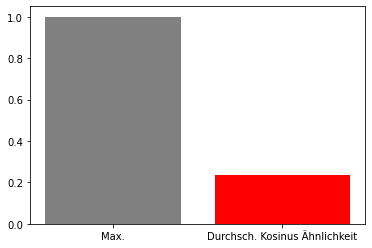

Durchschnittswert der Kosinus-Ähnlichkeiten: 0.23508595762201656


In [188]:
all_cos_sim = 0
for i in range (len(data)):
    # Für jeden Film werden die Top 5 Vorhersagen kalkuliert
    make_recommendation([data["title"][i]])
    
for i in list_cos_sim:
    all_cos_sim += i

plt.bar(['Max.', 'Durchsch. Kosinus Ähnlichkeit'], [1, all_cos_sim / len(list_cos_sim)], color=['grey', 'red'])
plt.show()
print("Durchschnittswert der Kosinus-Ähnlichkeiten:", all_cos_sim / len(list_cos_sim))

# MAE (Mean und RMSE Berechnung (Statistische Ungenauigkeit der Vorschläge)
# MAE: 1/n * Σ |Vorhersage - reale Bewertung|
# RMSE: sqrt( (Σ |Vorhersage - reale Bewertung|)**2 / n)
wobei n = Anzahl der Vorhersagen (6 pro Film - 4395 * 6 = 26370  )

# Hier werden für jeden Film einzelnd die Top 6 Vorschläge ausgerechnet und der MAE / RMSE (wie oben) bestimmt. Die Werte der Kosinus-Ähnlichkeit werden mit den realen Bewertungen verrechnet
# Je niedriger der Wert, desto genauer die Vorhersagen (zwischen 0 und 1)

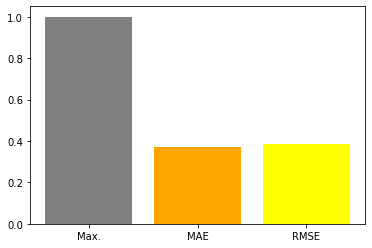

MAE: Die Ungenauigkeit der Vorschläge liegt bei 0.37302993059054534 ( 37.302993059054536 %)
RMSE: Die Ungenauigkeit der Vorschläge liegt bei 0.387139571757363 ( 38.7139571757363 %)


In [193]:
all_mae = 0
all_rmse = 0
for i in range (len(data)):
    # Für jeden Film werden die Top 5 Vorhersagen kalkuliert
    make_recommendation([data["title"][i]])
    
# Nun wird die Summe des ersten Teils der MAE berechnet...
for i in mae_list:
    all_mae += i
    # ... und dann durch die Anzahl der Vorhersagen geteilt
result_mae = (1/len(mae_list)) * all_mae
    
for j in rmse_list:
    all_rmse += j
result_rmse = sqrt((all_rmse)/ len(rmse_list))

plt.bar(['Max.', 'MAE', 'RMSE'], [1, result_mae, result_rmse], color=['grey', 'orange', 'yellow'])
plt.show()

print("MAE: Die Ungenauigkeit der Vorschläge liegt bei", result_mae, "(", result_mse * 100, "%)")
print("RMSE: Die Ungenauigkeit der Vorschläge liegt bei", result_rmse, "(", result_rmse * 100, "%)")

# Anschließend die Listen wieder leeren für weitere Durchgänge
mae_list = [] 
rmse_list = [] 

# Abdeckung (Coverage)
# Hier werden für jeden Film einzelnd die Top 6 Vorschläge ausgerechnet, diese Vorschläge dann in eine Menge gepackt und anschließend die Anzahl an vorgeschlagenen Filmen mit der Gesamtnzahl an Filmen in dem Datenset dividiert
# -> Der Prozentsatz an Filmen, die durch unser Modell vorgeschlagen werden.

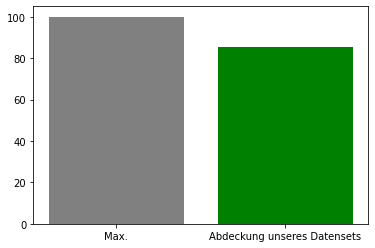

Abdeckung: 85.43799772468714 %


In [194]:
len_data = len(data)
for i in range (len(data)):
    # Für jeden Film werden die Top 5 Vorhersagen kalkuliert
    make_recommendation([data["title"][i]])
    
plt.bar(['Max.', 'Abdeckung unseres Datensets'], [100, (len(list_index) / len_data)*100], color=['grey', 'green'])
plt.show()

print("Abdeckung:", (len(list_index) / len_data)*100, "%")

# Abwanderung der Vorschläge (Churn)
# Durch unseren Algorithmus ist die Verschiedenheit der Vorschläge nicht gegeben; es werden stets die gleichen Vorschläge gemacht